<a href="https://colab.research.google.com/github/atvrai/ML_Implementation_2025/blob/main/SVM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


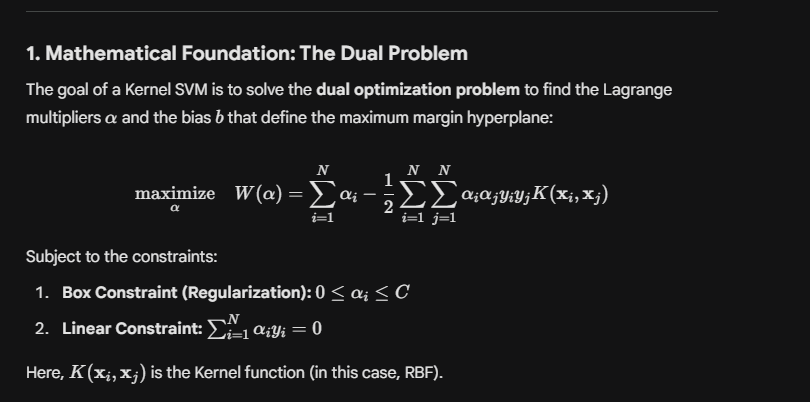

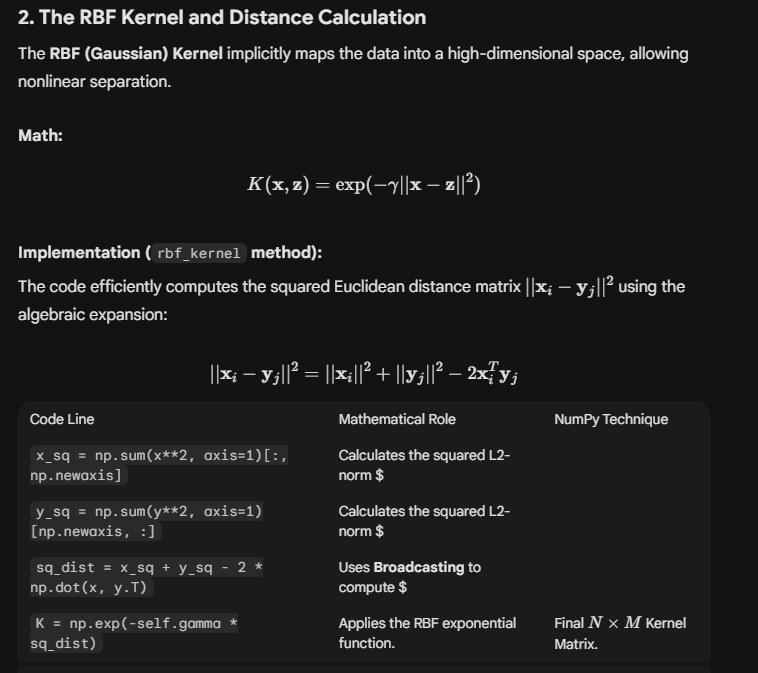

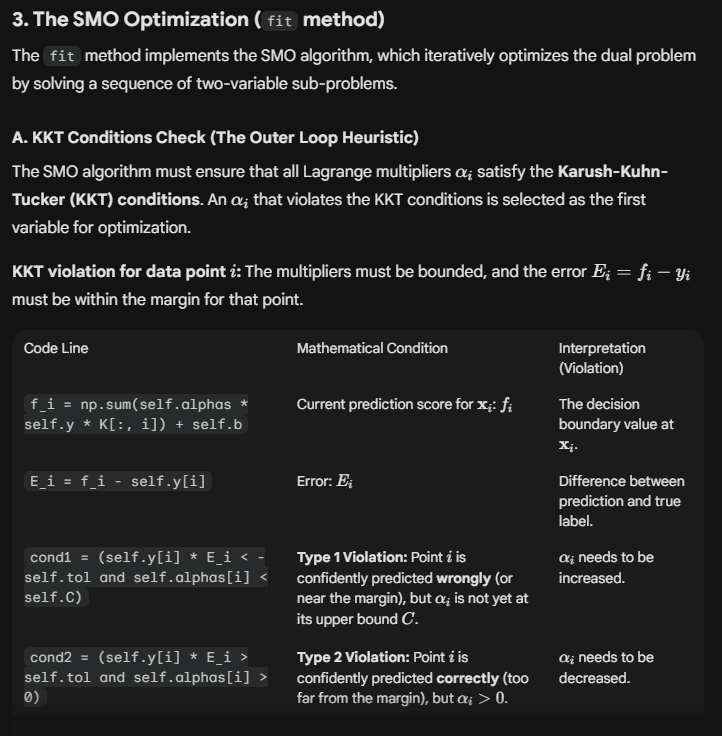

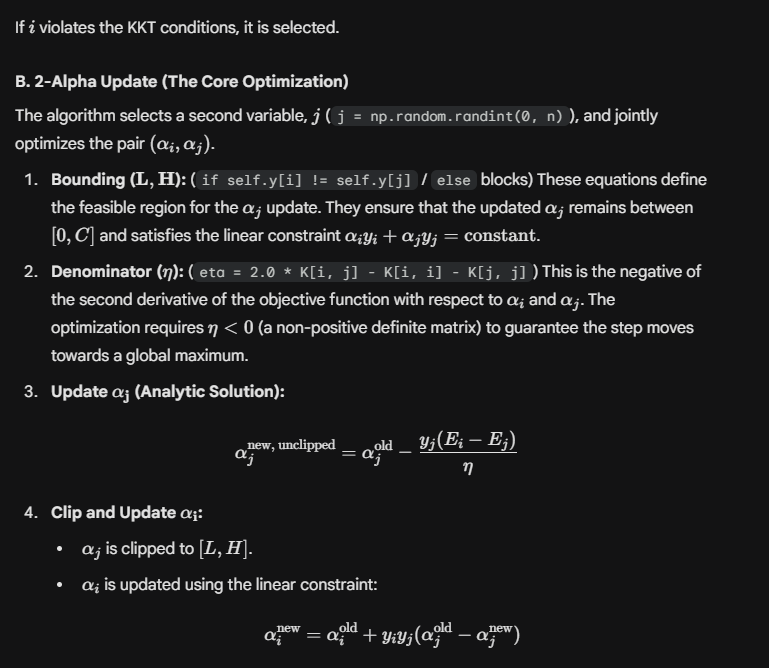

Bias ($\mathbf{b}$) Update: (if 0 < self.alphas[i] < self.C: ...)The bias is updated using the equation that guarantees the prediction $f(\mathbf{x})$ is exactly $\pm 1$ for a Support Vector whose $\alpha$ is strictly between $0$ and $C$ (i.e., a margin SV).C. TerminationThe loop terminates when one of two conditions is met:The maximum number of total iterations (self.max_iters) is reached.The number of passes (passes) without any $\alpha$ changes reaches self.max_passes.

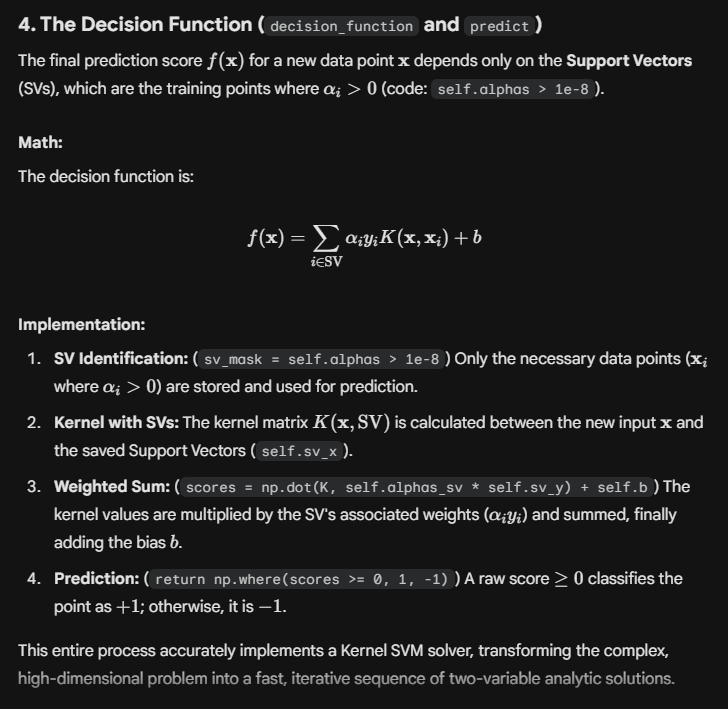

In [38]:
class KernelSVM:
  """
  SMO (Sequential Minimal Optimization) is the actual workhorse algorithm that trains the SVM model.
  Training an SVM involves solving a complex optimization challenge called a Quadratic Programming (QP) problem.
  This problem finds the set of Lagrange multipliers ($\alpha_i$) that maximize the margin, subject to certain constraints.
  For a large dataset ($N$ data points), solving this QP problem is incredibly slow and complex for standard solvers,
  as the number of variables is equal to the number of data points.

  Kernel SVM using simplified SMO (Platt) and RBF kernel.
  - y must be in {-1, +1}
  - C: regularization parameter
  - gamma: RBF kernel parameter (K(x,z) = exp(-gamma * ||x-z||^2)) kerenl function going to use
  - tol: numerical tolerance for KKT checks #Karush-Kuhn-Tucker (KKT) conditions
  - max_passes: termination when no alphas change for this many passes

  Platt's Method (or Platt Scaling) is a post-processing technique developed by John Platt (in a separate work) that transforms
  the raw output of an SVM into a well-calibrated probability.
  """
  def __init__(self , C = 1.0 , gamma = 0.5 , tol = 1e-3 , max_passes=5 , max_iters = 1e5 , verbose = False):
    # returns kernel matrix between rows of X and rows of Y (if Y None, use X)
    self.C = C
    self.gamma = gamma
    self.tol = tol
    self.max_passes = max_passes
    self.max_iters = max_iters
    self.verbose = verbose

#this distance formula is based on the expansion of the old ||x-y|^2| = ||x^2|| + ||y^2|| - 2*|X||Y|
  def rbf_kernel(self , x , y=None):
    if y is None:
      y=x
    x_sq = np.sum(x**2 , axis = 1)[:,np.newaxis] #calculates the squared magnitude (or squared L2 norm) of every vector in the x matrix and prepares it as a column vector.
    #Reshaping it from NxD to Nx1
    y_sq = np.sum(y**2 , axis = 1)[np.newaxis,:] #converselt this does the opposite...Converts the flat array into an explicit row vector 1xM
    sq_dist = x_sq + y_sq - 2*np.dot(x,y.T)
    K = np.exp(-self.gamma*sq_dist)
    return K    #N*M matrix




  def fit(self , x , y):
    n , _ = x.shape #only care for n
    self.x = x.copy()
    self.y = y.copy().astype(float)
    self.alphas = np.zeros(n)
    self.b = 0.0

    # Precompute kernel matrix
    K = self.rbf_kernel(self.x)

    passes = 0
    iters = 0
    while passes < self.max_passes and iters < self.max_iters:
      num_changed_alphas = 0
      for i in range(n):
        iters += 1

        # compute f(x_i)
        f_i = np.sum(self.alphas * self.y * K[:, i]) + self.b
        E_i = f_i - self.y[i]

        # Check KKT conditions (with tolerance)
        cond1 = (self.y[i] * E_i < -self.tol and self.alphas[i] < self.C)
        cond2 = (self.y[i] * E_i > self.tol and self.alphas[i] > 0)

        if not (cond1 or cond2):
          continue
        #conditions of KKT not satisfied...

        j = i
        while j == i:
            j = np.random.randint(0, n) #picking a random j!=i

        f_j = np.sum(self.alphas * self.y * K[:, j]) + self.b #computes sum of all row along the colum j ?
        E_j = f_j - self.y[j]

        alpha_i_old = self.alphas[i].copy()
        alpha_j_old = self.alphas[j].copy()

        if self.y[i] != self.y[j]:
          L = max(0.0, self.alphas[j] - self.alphas[i]) #LOWER BOUND
          H = min(self.C, self.C + self.alphas[j] - self.alphas[i]) #UPPER BOUND
        else:
            L = max(0.0, self.alphas[i] + self.alphas[j] - self.C)
            H = min(self.C, self.alphas[i] + self.alphas[j])
        if L == H:
            continue


        # compute eta :->
        eta = 2.0 * K[i, j] - K[i, i] - K[j, j]
        if eta >= 0:
            # non-positive definite step; skip (common simplified SMO behavior)
            continue

        # update alpha_j
        self.alphas[j] = alpha_j_old - (self.y[j] * (E_i - E_j)) / eta

        # clip
        if self.alphas[j] > H:
            self.alphas[j] = H
        elif self.alphas[j] < L:
            self.alphas[j] = L

        if abs(self.alphas[j] - alpha_j_old) < 1e-8:
          # change is too small
          self.alphas[j] = alpha_j_old
          continue

        # update alpha_i
        self.alphas[i] = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - self.alphas[j])


        # compute b1 and b2
        b1 = self.b - E_i - self.y[i] * (self.alphas[i] - alpha_i_old) * K[i, i] - self.y[j] * (self.alphas[j] - alpha_j_old) * K[i, j]
        b2 = self.b - E_j - self.y[i] * (self.alphas[i] - alpha_i_old) * K[i, j] - self.y[j] * (self.alphas[j] - alpha_j_old) * K[j, j]


        # update b
        if 0 < self.alphas[i] < self.C:
            self.b = b1
        elif 0 < self.alphas[j] < self.C:
            self.b = b2
        else:
            self.b = 0.5 * (b1 + b2)

        num_changed_alphas += 1

        if self.verbose and iters % 1000 == 0:
          print(f"iter {iters}, changed {num_changed_alphas} alphas, passes {passes}")

      if num_changed_alphas == 0: #no changes made pass again..
          passes += 1
      else:
        passes = 0


      # After optimization, save support vectors for decision boundry.
      sv_mask = self.alphas > 1e-8
      self.alphas_sv = self.alphas[sv_mask]
      self.sv_x = self.x[sv_mask]
      self.sv_y = self.y[sv_mask]
      if self.verbose:
          print(f"Training finished after {iters} iterations. Support vectors: {len(self.alphas_sv)}")
      return self


  def decision_function(self, x):
        # compute decision function using support vectors only
        if x.ndim == 1:
            x = x.reshape(1, -1)
        # compute kernel between X and support vectors
        # K(x, sv) shape -> (n_samples, n_sv)
        x_sq = np.sum(x**2, axis=1)[:, np.newaxis]
        SV_sq = np.sum(self.sv_x**2, axis=1)[np.newaxis, :]
        sq_dists = x_sq + SV_sq - 2 * np.dot(x, self.sv_x.T)
        K = np.exp(-self.gamma * sq_dists)
        scores = np.dot(K, self.alphas_sv * self.sv_y) + self.b
        return scores.ravel()

    #fucntion to call predict scores
  def predict(self, x):
        scores = self.decision_function(x)
        return np.where(scores >= 0, 1, -1)

In [39]:
x, y = make_circles(n_samples=400, factor=0.3, noise=0.08, random_state=0)
y = np.where(y == 0, -1, 1)   # convert to -1,+1
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Train kernel SVM
svm = KernelSVM(C=1.0, gamma=5.0, tol=1e-3, max_passes=10 ,verbose=True) #obj created
svm.fit(x_train, y_train)

# Predict and evaluate
y_pred = svm.predict(x_test)


Training finished after 280 iterations. Support vectors: 67


In [40]:
def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred)) #remember float or it will be done in int maybe...


In [41]:
print("Test accuracy:", accuracy(y_test, y_pred))

Test accuracy: 1.0
